# Notebook to address issues with Drosophila spike detection

The spike threshold seems way off, but this may not be the only issue

## Imports

In [150]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from mosquito.util import idx_by_thresh, butter_highpass_filter, butter_bandpass_filter
from mosquito.process_abf import load_processed_data, detrend_emg

## Params

In [151]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


## Load data

In [152]:
# load processed data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '27_20240528'  # '28_20240529'  #  '17_20240507'
axo_num = 0
# vid_str = 'aedes_C001H001S0001_20240326_154951'
data = load_processed_data(data_folder, axo_num)

In [153]:
# read data into memory
t = data['time']  
emg_filt = data['emg_filt']
emg = data['emg']
spike_idx = data['spike_idx']

window = data['params']['emg_window']
fs = data['sampling_freq']

In [154]:
spike_idx

array([ 254425,  257227,  260368, ..., 4031520, 4033783, 4042237])

Text(0.5, 0, 'time (s)')

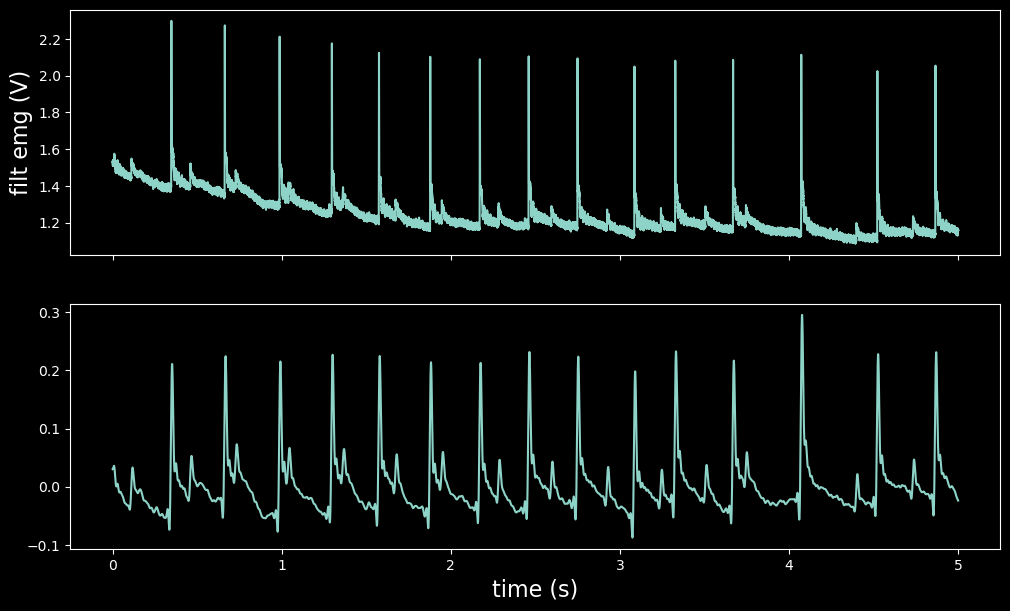

In [173]:
# plot filtered emg data
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,7),sharex=True)


tmin = 0 # 5
tmax = 5
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)

ax0.plot(t[mask], emg[mask])
ax0.plot(t[spike_idx][mask_spikes], emg[spike_idx][mask_spikes], 'rx')
ax0.set_ylabel('emg (V)')

ax1.plot(t[mask], emg_filt[mask])
ax1.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')
ax0.set_ylabel('filt emg (V)')

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_xlabel('time (s)')

## Try another pass at filtering data

In [180]:
# set new bandpass levels
lowcut = 10
highcut = 10000

emg_filt_new = butter_bandpass_filter(emg, lowcut, highcut, (1/fs))


In [181]:
# # try an additional bandstop?
# lowcut = 140
# highcut = 200
# emg_filt_new2 = butter_bandpass_filter(emg_filt_new, lowcut, highcut, (1/fs), btype='bandstop')

In [182]:
# try detrending data
emg_filt_new2 = detrend_emg(emg_filt_new, window=1028)


Text(0.5, 0, 'time (s)')

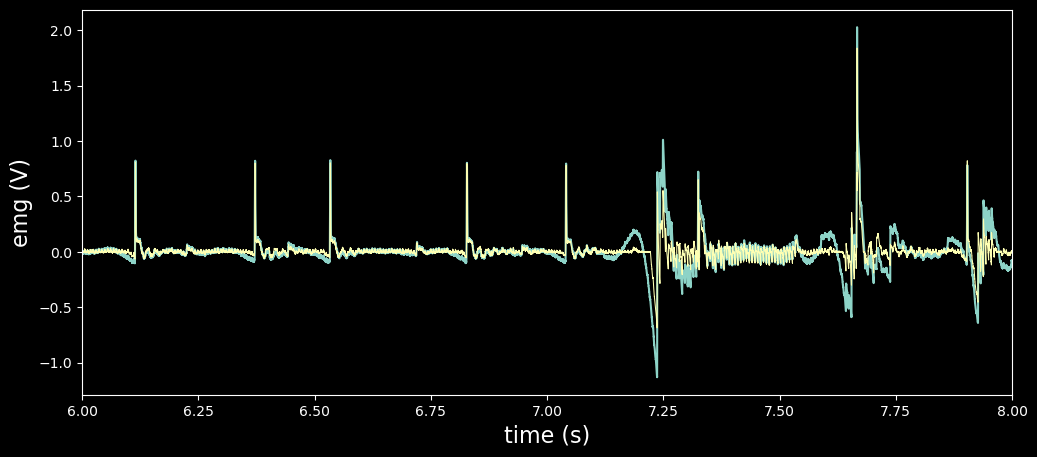

In [189]:
# compare
fig, ax = plt.subplots(figsize=(12,5))


tmin = 6 # 5
tmax = 8
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], emg_filt_new[mask])
# ax.plot(t[mask], emg[mask], lw=0.75)
ax.plot(t[mask], emg_filt_new2[mask], lw=0.75)

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')

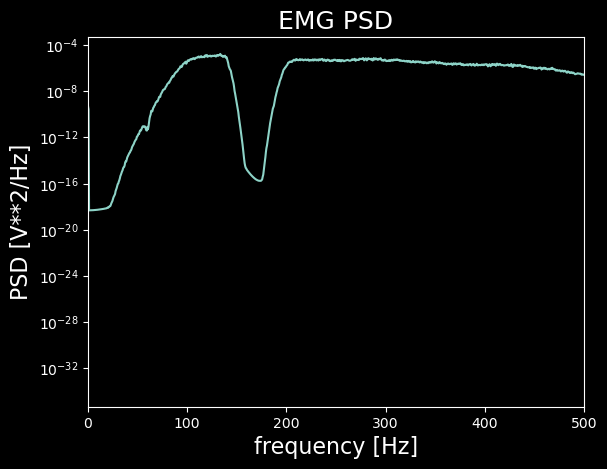

In [141]:
# check out emg PSD
nperseg = 4*16384  # 1028
f, Pxx_den = signal.welch(emg_filt_new2, fs, nperseg=nperseg)

fig, ax = plt.subplots()
ax.semilogy(f, Pxx_den)
# plt.ylim([0.5e-3, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_title('EMG PSD')
ax.set_xlim([0, 500])
plt.show()